<a href="https://colab.research.google.com/github/urielzan/OceanHackathon_uriel/blob/master/afaiMask_ee_S2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import folium

# Sargazum coordinates
#latMin = 21.53
#lonMin = -86.63
#latMax = 21.58
#lonMax = -86.58

latMin = 21.6
lonMin = -86.3
latMax = 21.8
lonMax = -86.2

dateMin = "2019-07-05"
dateMax = "2019-07-07"

cloudCov = 100 

coor= [(latMin,lonMin),(latMax,lonMax)]

map = folium.Map(
    location=[((latMax-latMin)/2)+latMin, ((lonMax-lonMin)/2)+lonMin],
    tiles='openstreetmap',
    zoom_start=10)
folium.LatLngPopup().add_to(map)

box = folium.vector_layers.Rectangle(coor,color="red",fill_color="red")


map.add_child(box)


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/tQHvvYGWQFIzmwW-FtAyJ6OXkekYe5sVjljkDVVxehm2CgNOTX0ZOPk

Successfully saved authorization token.
 number of image:  2


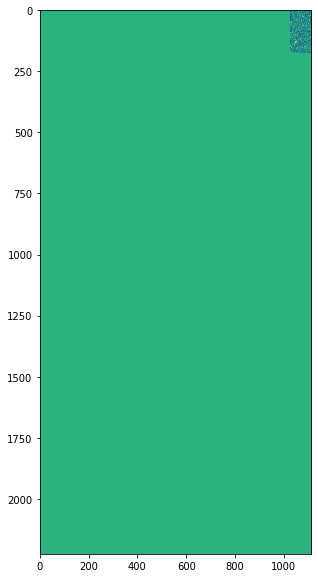

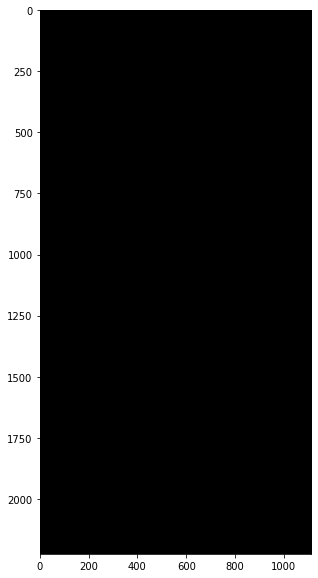

In [133]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 15 11:44:56 2019

@author: urielm
"""

import ee
import numpy as np
from osgeo import gdal
from osgeo import osr
#import time
from pyproj import Proj,transform
 
# code of google earth
ee.Authenticate()

# init the ee object
ee.Initialize()


 
# Define the roi

area = ee.Geometry.Polygon([[lonMin,latMin],\
                            [lonMax,latMin],\
                            [lonMax,latMax],\
                            [lonMin,latMax],\
                            [lonMin,latMin]])
 
 
# define the image
collection = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(area)\
                                      .filterDate(dateMin,dateMax)\
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",cloudCov)\
                                      .select(['B8','B4','B11'])
 
print(" number of image: ",collection.size().getInfo())
 
# perform any calculation on the image collection here
def anyFunction(img):
    afai = img.expression(
    'NIR-(RED+((859-645)/(1240-645))*(SWIR-RED))', {
      'NIR': img.select('B8'),
      'RED': img.select('B4'),
      'SWIR': img.select('B11')
})
    return afai
 
# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
 
    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e13,\
                                        scale=10);
 
    data = np.array((ee.Array(img.get("result")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data
 
# covert the lat, lon and array into an image
def toImage(lats,lons,data):
 
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999
 
    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr
 
    
def creaTiff(data, name, xmin, ymin, xmax, ymax, nx, ny):
    
    # Parametros para la creacion del TIFF por medio de GDAL
    xres = (xmax - xmin) / float(ny)
    yres = (ymax - ymin) / float(nx)
    geotransform = (xmin, xres, 0, ymax, 0, -yres)
    dst_ds = gdal.GetDriverByName('GTiff').Create(name+'.tif', ny, nx, 1, gdal.GDT_Float32)

    # Aplica la geotransformacion y la proyección
    dst_ds.SetGeoTransform(geotransform)    # Coordenadas especificas
    srs = osr.SpatialReference()            # Establece el ensamble
    srs.ImportFromProj4("+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs") # Proeyeccion Goes16
    dst_ds.SetProjection(srs.ExportToWkt()) # Exporta el sistema de coordenadas
    dst_ds.GetRasterBand(1).WriteArray(data)   # Escribe la banda al raster
    dst_ds.FlushCache()                     # Escribe en el disco

dst_ds = None


# map over the image collection
myCollection  = collection.map(anyFunction)
 
# get the median
result = ee.Image(myCollection.median()).rename(['result'])
 
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(result)
 
# 1d to 2d array
image  = toImage(lat,lon,data)
 
# scale factor and mask
image = image*0.001
image_mask = np.where(image <= 0.1,0,1)

# Georreferency image
p1 = Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
p2 = Proj('+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs')
xmin,ymin= -86.63,21.53
xmax,ymax = -86.58,21.58
xmin_utm,ymin_utm = transform(p1,p2,xmin,ymin)
xmax_utm,ymax_utm = transform(p1,p2,xmax,ymax)

# create Gtiff
creaTiff(image_mask,'afai_mask',xmin_utm,ymin_utm,xmax_utm,ymax_utm,image.shape[0],image.shape[1])

# in case you want to plot the image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(image_mask,cmap='gray')
plt.show()